In [1]:
import scipy.io as sio
import scipy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as op
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import os
import torchvision.transforms as tt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as Fun
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import math

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_input = []
train_answer1 = []
train_answer2 = []

test_input = []
test_answer1 = []
test_answer2 = []

val_input = []
val_answer1 = []
val_answer2= []
for SIR in range(0,11):
    data= sio.loadmat('/home2/LIG/BPSK_LFM_Overlap_data/sir_'+str(SIR)+'_dB.mat')
    overlap = data['overlap_stft']
    radar = data['lfm_stft']
    comm = data['bpsk_stft']

    train_overlap = overlap[0:250]
    val_overlap = overlap[250:280]
    test_overlap = overlap[280:300]

    train_radar = radar[0:250]
    val_radar = radar[250:280]
    test_radar = radar[280:300]

    train_bpsk = comm[0:250]
    val_bpsk = comm[250:280]
    test_bpsk = comm[280:300]
    
    train_input.append(train_overlap)
    train_answer1.append(train_radar)
    train_answer2.append(train_bpsk)
    
    test_input.append(test_overlap)
    test_answer1.append(test_radar)
    test_answer2.append(test_bpsk)

    val_input.append(val_overlap)
    val_answer1.append(val_radar)
    val_answer2.append(val_bpsk)


/home/siho0201/anaconda3/envs/dl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cv2
def otsu_thresholding(images):
    # 결과를 저장할 빈 배열을 생성합니다.
    binary_images = np.zeros_like(images)

    for idx, image in enumerate(images):
        image = image.astype(np.uint8)
        _, binary_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # 결과를 binary_images 배열에 저장합니다.
        binary_images[idx] = binary_img

    return binary_images

def normalize(images):
    nor_images = np.zeros_like(images)
    for idx, image in enumerate(images):
        # 이미지의 픽셀 값 범위를 0 ~ 255로 변환합니다.
        min_val = image.min()
        max_val = image.max()
        img = (image - min_val) / (max_val - min_val) * 255
        nor_images[idx] = img

    return nor_images

# def iq(input):
#     I = np.real(input)
#     Q = np.imag(input)

#     I_channel = np.expand_dims(I, axis=1)  # 가장 앞쪽 차원에 채널 추가
#     Q_channel = np.expand_dims(Q, axis=1)  # 가장 앞쪽 차원에 채널 추가

#     output_data = np.concatenate((I_channel, Q_channel), axis=1) 
    # return output_data

def iq_nor(input):
    I = np.abs(input)
    Q = np.angle(input)
    I_min = I.min(axis=(2, 3), keepdims=True)
    I_max = I.max(axis=(2, 3), keepdims=True)
   
    I = (I - I_min) / (I_max - I_min)
    Q = Q/np.pi
    I_channel = np.expand_dims(I, axis=1)  # 가장 앞쪽 차원에 채널 추가
    Q_channel = np.expand_dims(Q, axis=1)  # 가장 앞쪽 차원에 채널 추가

    output_data = np.concatenate((I_channel, Q_channel), axis=1) 
    return output_data


train_input = np.array(train_input)
train_answer1 = np.array(train_answer1)
train_answer2 = np.array(train_answer2)

val_input = np.array(val_input)
val_answer1 = np.array(val_answer1)
val_answer2 = np.array(val_answer2)

test_input = np.array(test_input)
test_answer1 = np.array(test_answer1)
test_answer2 = np.array(test_answer2)


train_input_nor = np.transpose(iq_nor(train_input),(0,2,1,3,4))
train_answer1_nor = np.transpose(iq_nor(train_answer1),(0,2,1,3,4))
train_answer2_nor = np.transpose(iq_nor(train_answer2),(0,2,1,3,4))

val_input_nor = np.transpose(iq_nor(val_input),(0,2,1,3,4))
val_answer1_nor = np.transpose(iq_nor(val_answer1),(0,2,1,3,4))
val_answer2_nor = np.transpose(iq_nor(val_answer2),(0,2,1,3,4))


test_input_nor = np.transpose(iq_nor(test_input),(0,2,1,3,4))
test_answer1_nor = np.transpose(iq_nor(test_answer1),(0,2,1,3,4))
test_answer2_nor = np.transpose(iq_nor(test_answer2),(0,2,1,3,4))

X_train = train_input_nor.reshape(-1,2,128,256)
y_train1 = train_answer1_nor.reshape(-1,2,128,256)
y_train2 = train_answer2_nor.reshape(-1,2,128,256)

X_val = val_input_nor.reshape(-1,2,128,256)
y_val1 = val_answer1_nor.reshape(-1,2,128,256)
y_val2 = val_answer2_nor.reshape(-1,2,128,256)

X_test = test_input_nor.reshape(-1,2,128,256)
y_test1 = test_answer1_nor.reshape(-1,2,128,256)
y_test2 = test_answer2_nor.reshape(-1,2,128,256)

# X_train = normalize(X_train)
# X_val = normalize(X_val)
# y_train = normalize(y_train)
# y_val = normalize(y_val)

In [3]:
class Train_data(Dataset): 
  def __init__(self):
    self.x_data = X_train
    self.y_data1 = y_train1
    self.y_data2 = y_train2
   
    # self.y_data = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]

 
  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx].astype(np.float32)
    y1 = self.y_data1[idx].astype(np.float32)
    y2 = self.y_data2[idx].astype(np.float32)
    # x = x/255
    # y = y/255

    x = torch.tensor(x,dtype = torch.float32)
    y1 = torch.tensor(y1,dtype = torch.float32)
    y2 = torch.tensor(y2,dtype = torch.float32)
    # x = Fun.normalize(x,p=2,dim=1)
    # y = Fun.normalize(y,p=2,dim=1)
    # print(x)
    # print(y)
    # y = Fun.one_hot(y,num_classes =4)
    return x, y1,y2

class val_data(Dataset): 
  def __init__(self):
    self.x_data = X_val
    self.y_data1 = y_val1
    self.y_data2 = y_val2
   
    # self.y_data = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]

 
  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx].astype(np.float32)
    y1 = self.y_data1[idx].astype(np.float32)
    y2 = self.y_data2[idx].astype(np.float32)
    # x = x/255
    # y = y/255

    x = torch.tensor(x,dtype = torch.float32)
    y1 = torch.tensor(y1,dtype = torch.float32)
    y2 = torch.tensor(y2,dtype = torch.float32)
    # x = Fun.normalize(x,p=2,dim=1)
    # y = Fun.normalize(y,p=2,dim=1)
    # print(x)
    # print(y)
    # y = Fun.one_hot(y,num_classes =4)
    return x, y1,y2
  
class test_data(Dataset): 
  def __init__(self):
    self.x_data = X_test
    self.y_data1 = y_test1
    self.y_data2 = y_test2
   
    # self.y_data = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]

 
  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx].astype(np.float32)
    y1 = self.y_data1[idx].astype(np.float32)
    y2 = self.y_data2[idx].astype(np.float32)
    # x = x/255
    # y = y/255

    x = torch.tensor(x,dtype = torch.float32)
    y1 = torch.tensor(y1,dtype = torch.float32)
    y2 = torch.tensor(y2,dtype = torch.float32)
    # x = Fun.normalize(x,p=2,dim=1)
    # y = Fun.normalize(y,p=2,dim=1)
    # print(x)
    # print(y)
    # y = Fun.one_hot(y,num_classes =4)
    return x, y1,y2

train_dataset = Train_data()
val_dataset = val_data()
test_dataset = test_data()
# transform = transforms.Compose([transforms.Normalize(mean=0.5,std=0.5)])
batch_size =32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=2, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1, padding=0, bias=True)
        self.sigmoid = nn.Sigmoid() 
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
       
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)
        

        return x

In [5]:
model1 = UNet()
model2 = UNet()
# if (DEVICE.type == 'cuda') and (torch.cuda.device_count() > 1):
#     print('Multi GPU activate')
#     model = nn.DataParallel(model, device_ids = list(range(NGPU)))
model1.to(DEVICE)
model2.to(DEVICE)

optimizer1 = op.AdamW(model1.parameters(),lr=0.0005)
optimizer2 = op.AdamW(model2.parameters(),lr=0.0005)


criterion1 = nn.MSELoss().to(DEVICE)
criterion2 = nn.MSELoss().to(DEVICE)

scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer1,
                                               lr_lambda=lambda epoch: 0.999 ** epoch,
                                               last_epoch=-1,
                                               verbose=False)

scheduler2 = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer2,
                                               lr_lambda=lambda epoch: 0.999 ** epoch,
                                               last_epoch=-1,
                                               verbose=False)

# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 0.9999 ** epoch,
#                                         last_epoch=-1,
#                                         verbose=False)

def saveModel():
    path1 = "./overlap_u-net_iq_total1.pth"
    path2 = "./overlap_u-net_iq_total2.pth"
    torch.save(model1.state_dict(),path1)
    torch.save(model2.state_dict(),path2)

def convert_to_complex_iq(tensor):    
    magnitude = tensor[:, 0]
    phase = tensor[:, 1]* np.pi
    real_part = magnitude * torch.cos(phase)
    imag_part = magnitude * torch.sin(phase)
    complex_tensor = torch.complex(real_part, imag_part)
    return complex_tensor

def convert_to_magnitude_phase(complex_iq_tensor):
    magnitude = torch.abs(complex_iq_tensor)
    phase = torch.angle(complex_iq_tensor)
    magnitude = torch.real(magnitude)  # Get real part of magnitude
    phase = torch.real(phase) / torch.tensor(math.pi)   # Get real part of phase
    mag_phase_tensor = torch.stack([magnitude, phase], dim=1)
    return mag_phase_tensor.squeeze()

y_pred = []
y_true = []
min_val_loss = float('inf')
print("----------------------Train start------------------------")
for epoch in range(1,1001):  # Train loop
    Train_loss1 = 0.0 
    Val_loss = 0.0 
    total = 0 
    Train_loss_arr = []
    # running_loss = 0.0
    for data in trainloader:
        train_inputs, train_labels1, train_labels2 = data
        # print(train_inputs)
        train_inputs = train_inputs.to(DEVICE) 
        train_labels1 = train_labels1.to(DEVICE) 
        train_labels2 = train_labels2.to(DEVICE) 

        output1 = model1(train_inputs)
        signal_tensor = convert_to_complex_iq(train_inputs) 
        radar_tensor = convert_to_complex_iq(output1.detach())
        output_mid = signal_tensor - radar_tensor
        # print(output_mid.size())
        output_mid2 = convert_to_magnitude_phase(output_mid)

        output2 = model2(output_mid2)

        Train_loss1 = criterion1(output1, train_labels1)
        optimizer1.zero_grad()
        Train_loss1.backward()
        optimizer1.step()

        Train_loss2 = criterion2(output2, train_labels2)
        optimizer2.zero_grad()
        Train_loss2.backward()
        optimizer2.step()
        

        Train_loss_arr += [Train_loss2.item()]

    scheduler1.step()
    scheduler2.step()
        # loss
    # Test Loop 
    with torch.no_grad():
        model1.eval()
        model2.eval()
        Val_loss_arr = []
        for data in valloader:
            val_inputs, val_labels1, val_labels2 = data
            val_inputs = val_inputs.to(DEVICE)
            val_labels1 = val_labels1.to(DEVICE)
            val_labels2 = val_labels2.to(DEVICE)
            
            output1 = model1(val_inputs)
            signal_tensor = convert_to_complex_iq(val_inputs) 
            radar_tensor = convert_to_complex_iq(output1)
            output_mid = signal_tensor - radar_tensor

            output_mid2 = convert_to_magnitude_phase(output_mid)

            output2 = model2(output_mid2)

            Val_loss1 = criterion1(output1, val_labels1)
            Val_loss2 = criterion2(output2, val_labels2)

            Val_loss_arr += [Val_loss2.item()]
        avg_val_loss = sum(Val_loss_arr) / len(Val_loss_arr)

         # 최소 검증 손실을 업데이트하고 모델을 저장합니다.
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            saveModel()
            print('saved best model with validation loss:', min_val_loss)
            

    print("----------------------End Train------------------------")
    print("EPOCH %04d | Train loss %.8f | Valid loss %.8f" %
                  (epoch, np.mean(Train_loss_arr),np.mean(Val_loss_arr)))


----------------------Train start------------------------
saved best model with validation loss: 0.16612377337047032
----------------------End Train------------------------
EPOCH 0001 | Train loss 0.19768286 | Valid loss 0.16612377
saved best model with validation loss: 0.16263400656836374
----------------------End Train------------------------
EPOCH 0002 | Train loss 0.19482236 | Valid loss 0.16263401
saved best model with validation loss: 0.1579976954630443
----------------------End Train------------------------
EPOCH 0003 | Train loss 0.15919775 | Valid loss 0.15799770
saved best model with validation loss: 0.15595543384552002
----------------------End Train------------------------
EPOCH 0004 | Train loss 0.15699568 | Valid loss 0.15595543
----------------------End Train------------------------
EPOCH 0005 | Train loss 0.15675508 | Valid loss 0.15748975
saved best model with validation loss: 0.15507000046116964
----------------------End Train------------------------
EPOCH 0006 | Trai

In [ ]:
torch.cuda.empty_cache()
model1 = UNet()
model1.load_state_dict(torch.load('overlap_u-net_iq_total1.pth'))
model1.eval()
model1.to(DEVICE)

model2 = UNet()
model2.load_state_dict(torch.load('overlap_u-net_iq_total2.pth'))
model2.eval()
model2.to(DEVICE)

inputs_arr = []
labels_arr = []
pred_arr = []


with torch.no_grad(): 
    for data in testloader: 
        test_inputs, test_labels1, test_labels2 = data 
        test_inputs = test_inputs.to(DEVICE) 
        test_labels1 = test_labels1.to(DEVICE) 
        test_labels2 = test_labels2.to(DEVICE) 

        output1 = model1(test_inputs)
        signal_tensor = convert_to_complex_iq(test_inputs) 
        radar_tensor = convert_to_complex_iq(output1)
        output_mid = signal_tensor - radar_tensor

        output_mid2 = convert_to_magnitude_phase(output_mid)

        output2 = model2(output_mid2)

        inputs_arr.append(test_inputs)
        labels_arr.append(test_labels2)
        pred_arr.append(output2)



In [ ]:
print(signal_tensor.size())

torch.Size([28, 1, 128, 256])


In [ ]:
pred_arr_cpu = [pred_arr[i].cpu().numpy() for i in range(len(pred_arr))]
pred_arr_np = np.concatenate(pred_arr_cpu, axis=0)
pred_arr_np = np.squeeze(pred_arr_np)
print(pred_arr_np.shape)

(220, 2, 128, 256)


In [ ]:
import scipy.io

pred_arr_cpu = [pred_arr[i].cpu().numpy() for i in range(len(pred_arr))]
pred_arr_np = np.concatenate(pred_arr_cpu, axis=0)
pred_arr_np = np.squeeze(pred_arr_np)
print(pred_arr_np.shape)
# pred_label = otsu_thresholding(pred_arr_np)
scipy.io.savemat('pred_label_total.mat', {'pred_label': pred_arr_np})

(220, 2, 128, 256)


In [ ]:
real_arr_cpu = [inputs_arr[i].cpu().numpy() for i in range(len(pred_arr))]
real_arr_np = np.concatenate(real_arr_cpu, axis=0)
real_arr_np = np.squeeze(real_arr_np)

labels_arr_cpu = [labels_arr[i].cpu().numpy() for i in range(len(pred_arr))]
labels_arr_np = np.concatenate(labels_arr_cpu, axis=0)
labels_arr_np = np.squeeze(labels_arr_np)

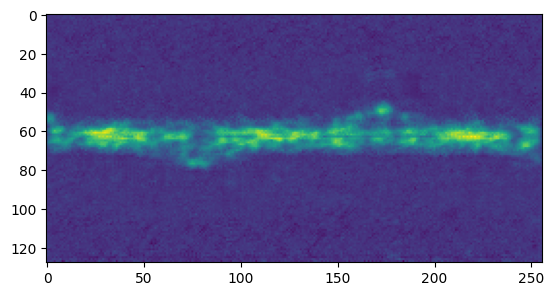

In [ ]:
pred =pred_arr_np[209][0]
ans = labels_arr_np[209][0]
plt.imshow(pred)


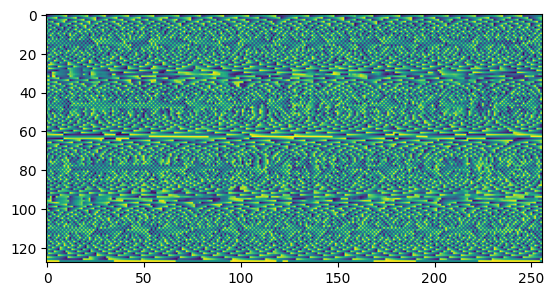

In [ ]:
plt.imshow(ans)

In [ ]:
# 첫 번째 미니 배치에서 이미지를 선택합니다.
sample_idx = 2  # 원하는 이미지 인덱스를 선택하세요.

input_images = [inputs_arr[i][sample_idx].cpu().numpy().squeeze() for i in range(len(inputs_arr))]
label_images = [labels_arr[i][sample_idx].cpu().numpy().squeeze() for i in range(len(labels_arr))]
pred_images = [pred_arr[i][sample_idx].cpu().numpy().squeeze() for i in range(len(pred_arr))]



In [ ]:
array = np.array(input_images)
print(array.shape)

(7, 2, 128, 256)
